# Проект "Формирование модели монетизации игрового приложения"

**Цель проекта** - проанализировать существующую систему монетизации игры «Космические братья», разработать предложения по ее оптимизации.  
В нашем распоряжении **данные**:  
- о действии игроков на первом уровне игры в разрезе даты, пользователя (id), вида события, типа постройки и реализованного проекта;
- источниках привлечения пользователях в разрезе пользователь-источник;
- стоимости рекламной кампании по каналам привлечения в разрезе даты, источника и стоимости кликов.
    
Текущая модель монетизации предполагает показ рекламы на экране с выбором типа объекта для постройки.  

Для выполнения основной цели проекта необходимо:  
- проанализировать поведение пользователей:  
    - определить долю завершивших первый уровень пользователей, 
    - определить частоту выбора каждой из стратегий завершения уровня, 
    - получить ключевые показатели (время пребывания в игре, количество построек) в зависимости от факта завершения или не завершения уровня и способа его завершения  
    
- определить частоту появления рекламных сообщений при различных стратегиях завершения первого уровня игры,
- просчитать окупаемость рекламы при условии использования действующей системы монетизации,
- проработать дополнительные варианты монетизации и просчитать окупаемость рекламы при условии использования новой системы монетизации,
- разработать и проверить статистические гипотезы по ключевым показателям действий пользователей в игре,
- по результам исследования сформировать предложения по текщему положению дел и предложить варианты оптимизации.


Ссылка на презентацию исследования:  
https://drive.google.com/file/d/1cZCoF647lznldLdGnCOaMbwOdN3YQ7ky/view?usp=sharing

## Предобработка данных:  
- соответствие типов значений 
- наименование столбцов (PEP 8)
- пропущенные значения (проверка наличия и замена в случае необходимости)
- дубликаты (явные и неявные) по всему DF
- уникальность значений отдельных столбцов (типа user_id)
- корректность распределение по кластерам (один пользователь - один кластер)

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import math as mth

In [3]:
local_path = "./"
server_path = "/datasets/"
files = ["user_source", "game_actions", "ad_costs"]
data_frames = []
for file in files:
    try:
        exec(f"data_{file} = pd.read_csv('{local_path}{file}.csv')")
        data_frames.append(f"data_{file}")
    except:
        exec(f"data_{file} = pd.read_csv('{server_path}{file}.csv')")
        data_frames.append(f"data_{file}")

In [4]:
for df in data_frames:
    print(df)
    locals().get(df).info()
    display(locals().get(df).head())
    print("\n", "_" * 50, "\n")

data_user_source
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads



 __________________________________________________ 

data_game_actions
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN



 __________________________________________________ 

data_ad_costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796



 __________________________________________________ 



In [5]:
data_game_actions["event_datetime"] = data_game_actions["event_datetime"].astype(
    "datetime64"
)

In [6]:
data_game_actions["date"] = data_game_actions["event_datetime"].dt.date

In [7]:
data_game_actions.head()

,event_datetime,event,building_type,user_id,project_type,date
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04


In [8]:
data_game_actions.duplicated().sum()

1

In [9]:
data_game_actions[data_game_actions.duplicated() == True]

,event_datetime,event,building_type,user_id,project_type,date
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN,2020-05-10


In [10]:
data_game_actions.drop_duplicates(inplace=True)

In [11]:
data_game_actions.groupby("event").agg(
    {"building_type": "unique", "project_type": "unique"}
)

,building_type,project_type
event,,
building,"[assembly_shop, spaceport, research_center]",[nan]
finished_stage_1,[nan],[nan]
project,[nan],[satellite_orbital_assembly]


In [12]:
data_user_source["source"].value_counts(dropna=False)

yandex_direct              4817
instagram_new_adverts      3347
facebook_ads               2726
youtube_channel_reklama    2686
Name: source, dtype: int64

In [13]:
data_user_source.duplicated().sum()

0

In [14]:
data_user_source["user_id"].nunique()

13576

In [15]:
data_user_source.groupby("user_id").count().query("source != 1")

,source
user_id,


In [16]:
data_ad_costs["day"] = pd.to_datetime(data_ad_costs["day"]).dt.date

In [17]:
data_ad_costs.duplicated().sum()

0

### Вывод  

1. DF 'data_game_actions' всего 135640 строк, 5 столбцов.  
    Наименования столбцов корректны, нет смешения стилей, разделитель в многословных названиях - подчеркивание. По типам данных необходимо только приведение столбца "event_datetime" к типу datetime, для дальнейшего выделения из нее даты.  
    Пропущенные значения есть в столбцах 'building_type' и 'project_type', но их замена не требуется, пропуски обусловлены логикой данных.
    Удалена одна дублирующая строка.
    
2. DF 'data_user_source' всего 13576 строк, 2 столбца.  
    Наименование строк корректны, пустые значения отсутствуют. Типы соответствуют размещенным в них данных. Дубликаты отсутствуют, NAN нет. Проверены на уникальность user_id, а также корректность отнесения пользователя только к одному источнику трафика.
    
3. DF 'data_ad_costs' всего 28 строк, 3 столбца. Типы соответствуют размещенным в них данных, кроме столбца с датой, ее необходимо привести к соответствующему типу. Дубликаты отсутствуют, пропущенные значения отсутствуют.

## Исследовательский анализ данных (EDA)

### DF 'game_actions' данные по игре пользователей на первом уровне

- проанализировать распределение числа пользователей по дням и событиям 
- проанализировать распределение числа пользователей по дням и этапам строительства проекта

In [18]:
users = data_game_actions["user_id"].nunique()
print(f"Общее число уникальных пользователей: {users}")

Общее число уникальных пользователей: 13576


In [19]:
# проверка согласованности данных в DF (все привлеченные пользователи совершили хотя бы 1 действие в игре)
users_acts = data_game_actions.groupby("user_id").agg({"event": "count"})
us_merge = data_user_source.merge(users_acts, on="user_id")
us_merge[us_merge["event"].isna()]

,user_id,source,event


In [20]:
min_date = data_game_actions["date"].min()
max_date = data_game_actions["date"].max()
print(
    f"Максимальная дата действий пользователей: {max_date}\nМинимальная дата действий пользователей: {min_date}"
)

Максимальная дата действий пользователей: 2020-06-05
Минимальная дата действий пользователей: 2020-05-04


Количество уникальных пользователей на первом уровне игры 13576 человек. Далее посмотрим сколько из них завершило и не завершило первый уровень, какая стратегия игры более популярна. Так же сделали дополнительную проверку, что каждый из привлеченных пользователей совершил хотя бы одно действие в игре (было показано хотя бы одно рекламное сообщение). Результат проверки положительный, все пользователи просмотрели рекламное сообщение хотя бы один раз.
    
Период доступных данных для анализа достаточный - 31 день (с 04.05.2020 по 05.06.2020), это позволит увидеть в динамике поведение пользователей разных когорот на первом уровне игры. 


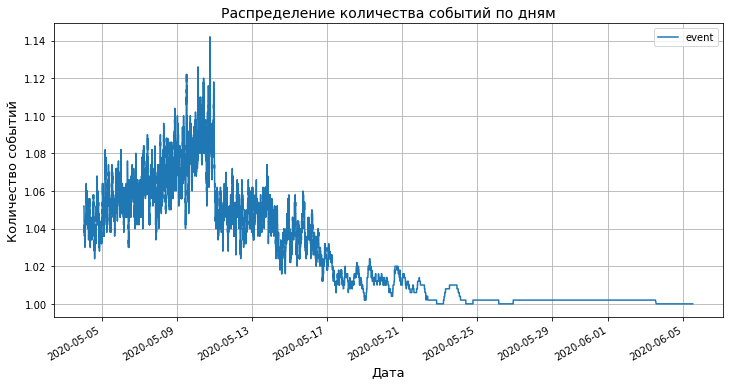

In [21]:
# построение графика числа событий по дням
event_day = data_game_actions.groupby("event_datetime").agg({"event": "count"})
event_day.rolling(500).mean().plot(
    grid=True,
    figsize=(12, 6),
)
plt.title("Распределение количества событий по дням", fontsize=14)
plt.ylabel("Количество событий", fontsize=13)
plt.xlabel("Дата", fontsize=13)
plt.legend = False
plt.show()

#### Вывод
Пик активности наблюдается в районе 10 мая, после этой даты постепенное снижение количества действий пользователей. К 5 мая показатель снизился до минимума и закрепился на этом уровне.

In [22]:
# получение данных по дням и видам собыйтий для дальнейшего построения графика
group_user_action = pd.DataFrame(data_game_actions["date"].unique(), columns=["date"])
for action in data_game_actions["event"].unique():
    group_user_action = group_user_action.merge(
        data_game_actions[data_game_actions["event"] == action]
        .groupby("date")
        .agg({"user_id": "nunique"}),
        on="date",
        how="left",
    ).fillna(0)

group_user_action.rename(
    columns=(
        {"user_id_x": "building", "user_id_y": "finished_stage_1", "user_id": "project"}
    ),
    inplace=True,
)

group_user_action.set_index("date", inplace=True)

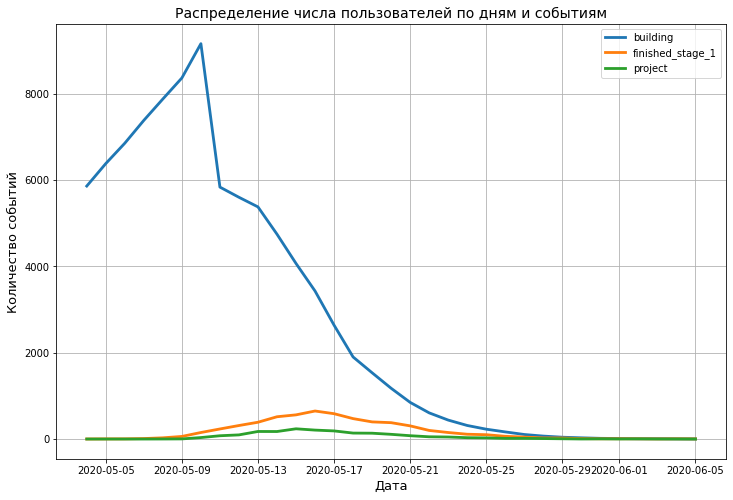

In [23]:
group_user_action.plot(grid=True, figsize=(12, 8), lw=2.8)
plt.title("Распределение числа пользователей по дням и событиям", fontsize=14)
plt.ylabel("Количество событий", fontsize=13)
plt.xlabel("Дата", fontsize=13)
plt.show()

In [24]:
data_game_actions.groupby("event").agg({"date": "min", "event_datetime": "first"})

,date,event_datetime
event,,
building,2020-05-04,2020-05-04 00:00:01
finished_stage_1,2020-05-04,2020-05-04 19:47:29
project,2020-05-08,2020-05-08 18:10:25


#### Вывод
Наиболее популярное действие - постройка здания, пик таких действий пришелся на 10 мая. Завершение уровня и постройка проекта гораздо более редкие события, причем завершение уровня появляется уже с первого дня запуска игры, а постройка проекта только на третий день. Путь к завершению через победу более короткий, с меньшим поличеством показа рекламы или с полностью ее отсутствием.

### DF 'ad_cost' данные по дням с указанием источника трафика и стоимость кликов 

- проанализировать распределение стоимости рекламы (описательные статистики) по каналам

In [25]:
for source in data_ad_costs["source"].unique():
    print(
        source, "\n", data_ad_costs[data_ad_costs["source"] == source].describe(), "\n"
    )

facebook_ads 
              cost
count    7.000000
mean   305.843520
std    326.542054
min     38.723350
25%     89.888036
50%    177.982200
75%    404.270117
max    935.882786 

instagram_new_adverts 
              cost
count    7.000000
mean   308.777384
std    322.254830
min     46.775400
25%     90.746997
50%    173.071145
75%    408.448217
max    943.204717 

yandex_direct 
              cost
count    7.000000
mean   319.015921
std    336.921909
min     42.779505
25%     88.695484
50%    180.917099
75%    431.442242
max    969.139394 

youtube_channel_reklama 
              cost
count    7.000000
mean   152.588458
std    155.552373
min     23.314669
25%     47.979276
50%     88.506074
75%    203.057483
max    454.224943 



#### Вывод
Среди всех каналов привлечения пользователей наименьшая стоимость (средняя, минимальная и максимальная) рекламы у youtube, остальные каналы (facebook, instagram и yandex) имеют близкие значения данных показателей.  
Для наглядности далее построим график динамики затрат на рекламу по каналам привлечения.

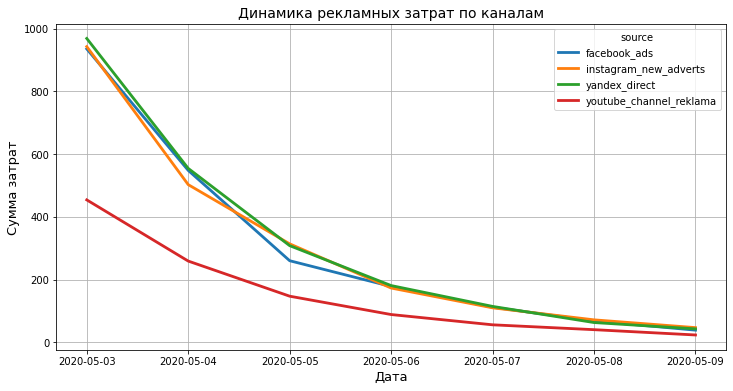

In [26]:
data_ad_costs.pivot_table(
    index="day",
    columns="source",
    values="cost",
    aggfunc="sum",
).plot(figsize=(12, 6), grid=True, lw=2.8)
plt.title("Динамика рекламных затрат по каналам", fontsize=14)
plt.ylabel("Сумма затрат", fontsize=13)
plt.xlabel("Дата", fontsize=13)
plt.show()

#### Вывод
Наибольшие суммы затрат по всем каналам за день до начала периода запуска приложения - 03 мая. Рекламная кампания продолжалась 7 дней до 09 мая. По всем каналам динамика затрат одинаковая - плавное снижение от первого к последнему дню.   
Стоимость затрат каналов facebook, instagram и yandex примерно на одном уровне, youtube реклама стоила меньше остальных.

### DF 'user_source' данные по источнику привлечения пользователей
- определить количество пользователей по каждому источнику привлечения

In [27]:
data_user_source["source"].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

In [28]:
data_user_source.groupby("source").agg({"user_id": "nunique"})

,user_id
source,
facebook_ads,2726
instagram_new_adverts,3347
yandex_direct,4817
youtube_channel_reklama,2686


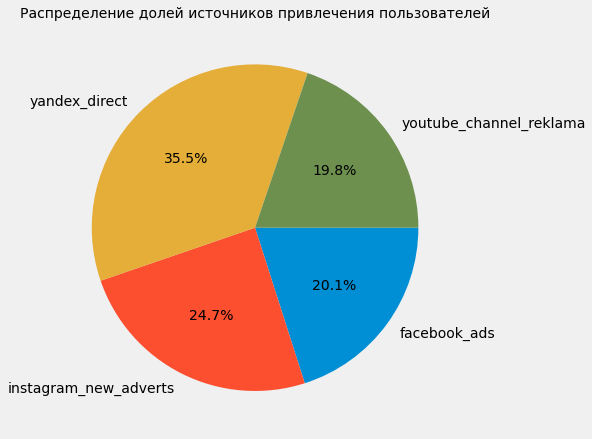

In [29]:
with plt.style.context("fivethirtyeight"):
    data_user_source.groupby("source").agg({"user_id": "nunique"}).plot.pie(
        y="user_id",
        figsize=(7, 7),
        autopct="%2.1f%%",
        legend=False,
        counterclock=False,
    ).set_ylabel(None)

    plt.title("Распределение долей источников привлечения пользователей", fontsize=14)

    plt.show()

#### Вывод
    
Основное действие в игре - постройка объекта космопорта, оно же "рекламное" действие при существующей системе монетизации. Однако начиная с первого дня игры, есть игроки завершившие первый уровень победой над другим игроком. Это говорит о узком месте в существующей системе монетизации - уровень можно завершить без показа рекламы или ее минимальным количеством. 

Относительно рекламных каналов получили следующие данные:  
- кампания была начата за день до запуска игры (03.05.2020);
- основной канал привлечения 'yandex-direct' (36% привлеченных пользователей), оставшиеся три привлекли 25%, 20% и 19% пользователей;
- стоимость затрат каналов facebook, instagram и yandex примерно на одном уровне, youtube реклама стоила меньше остальных.

## Создание портрета пользователя, прошедшего первый уровень

- способ завершения первого уровня игры
- среднее время пребывания в игре (когорты по первому дню вхождения)
- среднее количество действий в игре до завершения проекта

In [30]:
finishers = data_game_actions.query('event=="finished_stage_1"')["user_id"].reset_index(
    drop=True
)
finishers_builder = data_game_actions.query('event=="project"')["user_id"].reset_index(
    drop=True
)
finishers_warrior = pd.Series(list(set(finishers) - set(finishers_builder)))

print(
    f"Всего завершило первый уровень игры {finishers.shape[0]} игроков. \n"
    f"Это {finishers.shape[0]/users*100:.1f}% от общего числа пользователей. \n"
    f"Из них {finishers_builder.shape[0]} человек завершило уровень постройкой и {finishers_warrior.shape[0]} человек победой над другим игроком"
)

Всего завершило первый уровень игры 5817 игроков. 
Это 42.8% от общего числа пользователей. 
Из них 1866 человек завершило уровень постройкой и 3951 человек победой над другим игроком


Определим количество посетителей, запустивших приложение только 1 раз:

In [31]:
ones = data_game_actions.groupby("user_id").agg({"event": "count"})
ones[ones["event"] == 1].shape

(57, 1)

**Вывод**  
    
Всего за период наблюдений первый уровень завершило 43% игроков - 5817 человек. При этом только треть из них (1866 человек) завершили уровень постройкой, а остальные - победой над другим пользователем (3951 человек). Большинство пользователей выбрало "короткий" путь к завершению уровня, а мы недополучили таким образом рекламные просмотры.  


    
Также есть незначительное число игроков - 57 человек (менее 0,5% от общего числа пользователей), кто совершил только одно действие в игре. Это можно трактовать положительно, основная часть посетителей заинтересовалась нашим приложением.


Сгруппируем пользователей на когорты по дате первого входа в игру и определим размер каждой из них.  

Также для последующих вычислений рассчитаем лайфтайм каждого события каждого пользователя.  

Данные добавим к исходному DF.

In [32]:
cohort_info = (
    data_game_actions.groupby("user_id", as_index=False)
    .agg({"date": "first"})
    .rename(columns=({"date": "cohort_date"}))
)
cohort_size = (
    cohort_info.groupby("cohort_date")
    .agg({"user_id": "nunique"})
    .rename(columns=({"user_id": "cohort_size"}))
)
cohort_info = cohort_info.merge(cohort_size, on="cohort_date")

In [33]:
data_game_actions = data_game_actions.merge(cohort_info, on="user_id")
data_game_actions["lifetime"] = (
    data_game_actions["date"] - data_game_actions["cohort_date"]
).dt.days

In [34]:
data_game_actions.head()

,event_datetime,event,building_type,user_id,project_type,date,cohort_date,cohort_size,lifetime
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020-05-04,5860,0
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,5860,1
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,5860,1
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,5860,1
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06,2020-05-04,5860,2


In [35]:
finisher_per_cohort = (
    data_game_actions.query('event == "finished_stage_1"')
    .groupby("cohort_date")
    .agg({"user_id": "nunique"})
)
finisher_per_cohort = finisher_per_cohort.merge(
    cohort_info.iloc[:, 1:].drop_duplicates(), on="cohort_date"
).set_index("cohort_date")
finisher_per_cohort = (
    finisher_per_cohort.div(finisher_per_cohort["cohort_size"], axis=0)
    .drop("cohort_size", axis=1)
    .rename(columns={"user_id": "share_finishers"})
)
finisher_per_cohort = (finisher_per_cohort * 100).round(1)
finisher_per_cohort

,share_finishers
cohort_date,
2020-05-04,45.6
2020-05-05,45.0
2020-05-06,41.7
2020-05-07,37.2
2020-05-08,34.2
2020-05-09,30.5
2020-05-10,30.3


**Вывод**  
По численности пользователей прослеживается четкая закономерность - убывание рамера когорты от первому к седьмому дню и это несмотря на проведение рекламной кампании. Необходимо проанализировать саму рекламу и настройки таргетирования по ней.
В разрезе когорт большая доля завершивших первый уровень игроков наблюдается в начальных когортах, в первой этот показатель составляет 45,6%, а в седьмой только 30,3%. Из этого можно предположить, что более поздние лайфтаймы в игру пришло много нецелевых пользователей не заинтересованных в длительном прохождении.


Для создания профиля игрока напишем функцию, которая добавит информацию:  
* закончил игрок или нет первый уровень
* о способе окончания уровня
* количестве совершенных действий (любых, кроме завершения уровня)  
* продолжительности пребывания в игре

In [36]:
def profile(df):
    profile = (
        df.query('event == "building"')
        .groupby(
            [
                "user_id",
                "cohort_date",
            ],
            as_index=False,
        )
        .agg(
            {
                "event": "count",
                "lifetime": "max",
            }
        )
        .rename(
            columns={
                "event": "number_event",
                "lifetime": "duration",
            }
        )
    )

    profile["finisher"] = np.where(profile["user_id"].isin(finishers), 1, 0)

    profile["type_finisher"] = np.where(
        profile["finisher"] == 1,
        np.where(profile["user_id"].isin(finishers_builder), "b", "w"),
        "n",
    )
    profile = profile.merge(
        (df.groupby("user_id").agg({"date": "nunique"}) - 1), on="user_id"
    ).rename(columns={"date": "returns"})

    return profile

In [37]:
profiles = profile(data_game_actions)
profiles.head()

,user_id,cohort_date,number_event,duration,finisher,type_finisher,returns
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,13,14,0,n,7
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,9,12,0,n,5
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05,4,9,0,n,2
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,8,7,1,w,5
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05,12,17,0,n,8


In [38]:
group_cohort = (
    profiles.groupby(["cohort_date", "finisher"], as_index=False)
    .agg({"number_event": "mean", "duration": "mean"})
    .round(3)
)

Построим графики динамики среднего количества и распределения числа действий по когортам с учетом признака "первый уровень игры закончен" 

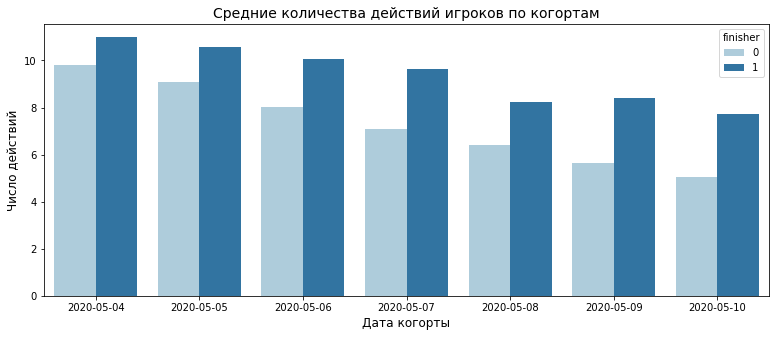

In [39]:
plt.figure(figsize=(13, 5))
bchart = sns.barplot(
    data=group_cohort,
    y="number_event",
    x="cohort_date",
    hue="finisher",
    palette="Paired",
)

plt.xlabel("Дата когорты", fontsize=12)
plt.ylabel("Число действий", fontsize=12)
plt.title("Средние количества действий игроков по когортам", fontsize=14)
plt.show()

Среднее число действий игроков закончивших первый уровень в зависимости от когорты составляет от 11,3 до 7,9.  
У незакончивших этот показатель ниже - от 9,8 до 5,1.

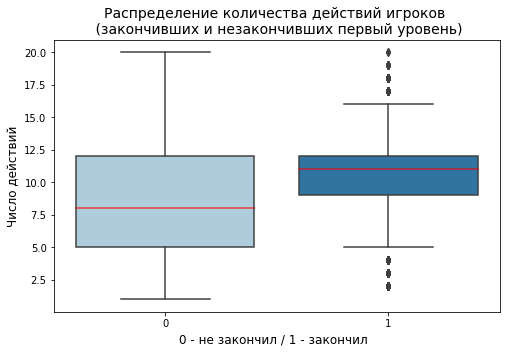

In [40]:
plt.figure(figsize=(8, 5))
boxchart = sns.boxplot(
    data=profiles,
    y="number_event",
    x="finisher",
    palette="Paired",
    medianprops=dict(color="red", alpha=0.7),
)

plt.xlabel("0 - не закончил / 1 - закончил  ", fontsize=12)
plt.ylabel("Число действий", fontsize=12)
plt.title(
    "Распределение количества действий игроков \n (закончивших и незакончивших первый уровень)",
    fontsize=14,
)
plt.show()

Распределение количества действий у игроков закончивших первый уровень распределено нормально относительно медианы (11), с небольшим количеством выбросов ниже  минимума и выше максимума.  
У тех, кто не закончил первый уровень медианное значение составляет 7,5, большая часть значений скошена к верхнему краю.

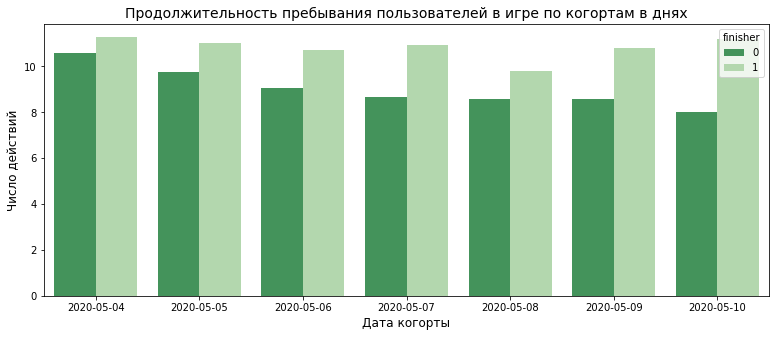

In [41]:
plt.figure(figsize=(13, 5))
bchart = sns.barplot(
    data=group_cohort,
    y="duration",
    x="cohort_date",
    hue="finisher",
    palette="Greens_r",
)
plt.xlabel("Дата когорты", fontsize=12)
plt.ylabel("Число действий", fontsize=12)
plt.title(
    "Продолжительность пребывания пользователей в игре по когортам в днях", fontsize=14
)
plt.show()

Продолжительность пребывания игроков закончивших первый уровень в зависимости от когорты составляет от 11,5 до 9,9 дней.  
У незакончивших этот показатель ниже - от 10,6 до 8,0 дней.  

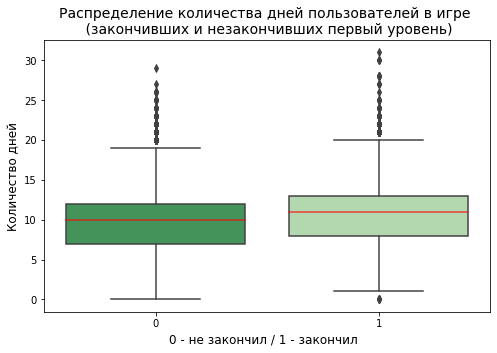

In [42]:
plt.figure(figsize=(8, 5))
boxchart = sns.boxplot(
    data=profiles,
    y="duration",
    x="finisher",
    palette="Greens_r",
    medianprops=dict(color="red", alpha=0.7),
)

plt.xlabel("0 - не закончил / 1 - закончил  ", fontsize=12)
plt.ylabel("Количество дней", fontsize=12)
plt.title(
    "Распределение количества дней пользователей в игре \n (закончивших и незакончивших первый уровень)",
    fontsize=14,
)
plt.show()

Распределение количества дней у игроков закончивших первый уровень распределено нормально относительно значения медианы 10, некоторым количеством выбросов ниже  минимума и выше максимума.  
У тех, кто не закончил первый уровень медианное значение также около 10 дней большая часть значений скошена к верхнему краю и присутсвуют выбросы выше максимума.

In [43]:
profiles.groupby(["finisher", "type_finisher"]).agg(
    {"number_event": "mean", "duration": "mean"}
).round(3)

number_event  duration
finisher type_finisher                        
0        n                     8.657     9.746
1        b                    12.648    12.093
         w                     9.412    10.549

Средняя продолжительность в днях у:  
- закончивших победой составляет 10,5 дней при 9,4 совершенных действиях
- закончивших постройкой составляет 12,9 дней при 13,6 совершенных действиях
- незакончивших уровень составляет 9,7 дней при 8,7 совершенных действиях.

In [44]:
profiles.groupby(["finisher"]).agg({"number_event": "mean", "duration": "mean"}).round(
    3
)

,number_event,duration
finisher,,
0,8.657,9.746
1,10.450,11.045


#### Вывод

Пользователь, закончивший первый уровень игры провел в ней большее число дней и произвел большее количество действий, чем тот кто его не закончил. При этом стратегия закончить постройкой занимает больше времени и требует больше действий, чем стратегия победой над противником.

### Оценка действующей системы монетизации

In [45]:
buildings = data_game_actions[data_game_actions["event"] == "building"]

group_buildings = buildings.pivot_table(
    index="date",
    columns="building_type",
    values="event",
    aggfunc="count",
).fillna(0)

group_buildings["total_event"] = group_buildings.iloc[:, :3].sum(axis=1)
group_buildings["total_money"] = group_buildings["total_event"] * 0.07
group_buildings["users"] = buildings.groupby("date").agg({"user_id": "nunique"})
group_buildings["event_per_user"] = (
    group_buildings["total_event"] / group_buildings["users"]
).round(3)
group_buildings["money_per_user"] = (
    group_buildings["total_money"] / group_buildings["users"]
).round(3)
group_buildings = group_buildings.reset_index(level=0)

In [46]:
group_buildings.describe().round(3)

building_type,assembly_shop,research_center,spaceport,total_event,total_money,users,event_per_user,money_per_user
count,33.000,33.000,33.000,33.000,33.000,33.000,33.000,33.000
mean,1651.333,428.394,1797.727,3877.455,271.422,2759.697,1.231,0.086
std,3231.974,537.057,2202.949,4617.749,323.242,3072.027,0.170,0.012
min,0.000,0.000,0.000,2.000,0.140,2.000,1.000,0.070
25%,0.000,11.000,37.000,81.000,5.670,68.000,1.143,0.080
50%,0.000,123.000,606.000,1349.000,94.430,1176.000,1.179,0.082
75%,0.000,833.000,3041.000,7509.000,525.630,5600.000,1.341,0.094
max,7869.000,1540.000,6585.000,15022.000,1051.540,9158.000,1.640,0.115


In [47]:
group_buildings.head()

building_type,date,assembly_shop,research_center,spaceport,total_event,total_money,users,event_per_user,money_per_user
0,2020-05-04,7767.0,0.0,403.0,8170.0,571.90,5860,1.394,0.098
1,2020-05-05,7816.0,0.0,1236.0,9052.0,633.64,6381,1.419,0.099
2,2020-05-06,7736.0,5.0,2180.0,9921.0,694.47,6853,1.448,0.101
3,2020-05-07,7775.0,31.0,3041.0,10847.0,759.29,7382,1.469,0.103
4,2020-05-08,7833.0,123.0,4074.0,12030.0,842.10,7877,1.527,0.107


Для наглядности построим график динамики построек в разрезе типа и даты.

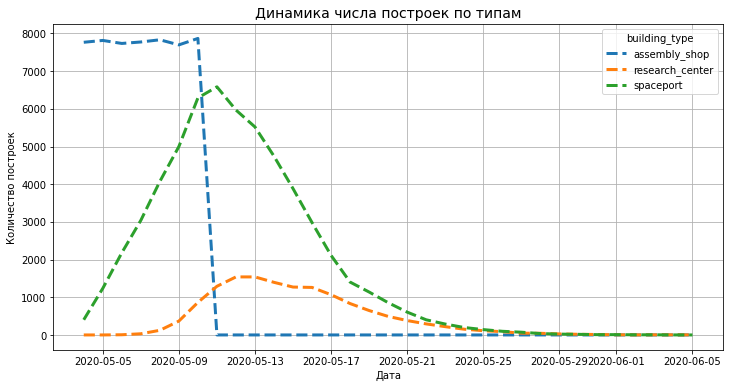

In [48]:
group_buildings.iloc[:, :4].set_index("date").plot(
    figsize=(12, 6),
    grid=True,
    linestyle="--",
    linewidth=3,
)
plt.xlabel("Дата")
plt.ylabel("Количество построек")
plt.title("Динамика числа построек по типам", fontsize=14)
plt.show()

На графике хорошо заметен резкий спад до нулевой отметки построек типа 'assembly_shop' 07 мая и в дальнейшем таких построек больше не было. Вероятность, что это связано с ошибками в программе выше, чем в сменившихся предпочтениях игроков. Данный вопрос необходимо передать в команду разработки. Также заметен пик числа построек типа "spaceport" в районе 10 мая, далее наблюдается спад. К 25 мая число построек всех типов упало практически до нуля. 

Далее построим график динамики числа построек по дням в расчете на 1 пользователя:

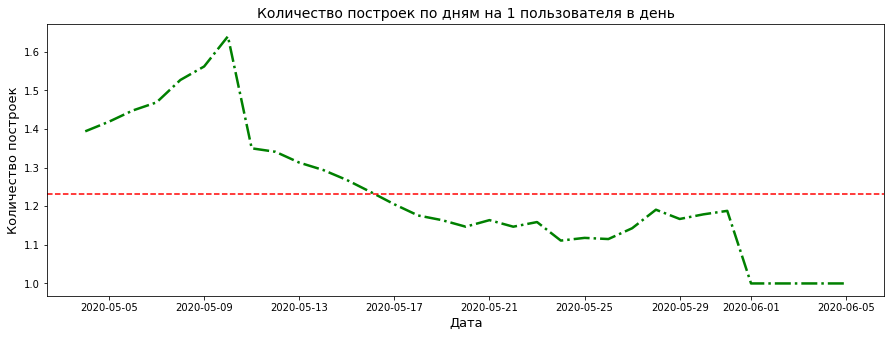

In [49]:
plt.figure(figsize=(15, 5))
lchart = sns.lineplot(
    data=group_buildings[["date", "event_per_user"]],
    y="event_per_user",
    x="date",
    linewidth=2.5,
    color="green",
    linestyle="-.",
)
plt.axhline(y=group_buildings["event_per_user"].mean(), color="red", linestyle="--")
plt.xlabel("Дата", fontsize=13)
plt.ylabel("Количество построек", fontsize=13)
plt.title("Количество построек по дням на 1 пользователя в день", fontsize=14)
plt.show()

In [50]:
print(
    f"Общее число рекламных показов (при выборе типа объекта при постройке) составило {group_buildings['total_event'].sum():.0f}.\n"
    f"В среднем на 1 одного уникального пользователя {group_buildings['total_event'].sum()/users:.1f} показов.\n"
    f"В среднем на 1 одного уникального пользователя в день {group_buildings['event_per_user'].mean():.1f} показов.\n\n"
    f"Общая сумма вознаграждения за рекламные показы составила {group_buildings['total_money'].sum():.0f} единиц.\n"
    f"Среднее вознаграждение на 1 одного уникального пользователя {group_buildings['total_money'].sum()/users:.1f} единиц.\n"
    f"Среднее вознаграждение на 1 одного уникального пользователя в день {group_buildings['money_per_user'].mean():.1f} единиц.\n\n"
    f"Общая сумма рекламных затрат {data_ad_costs['cost'].sum():.1f} единиц.\n\n"
    f"Доход от рекламных показов {group_buildings['total_money'].sum() - data_ad_costs['cost'].sum():.0f} единиц.\n"
    f"Рентабельность рекламных показов {(group_buildings['total_money'].sum() / data_ad_costs['cost'].sum() - 1):0.1%}.\n"
)

Общее число рекламных показов (при выборе типа объекта при постройке) составило 127956.
В среднем на 1 одного уникального пользователя 9.4 показов.
В среднем на 1 одного уникального пользователя в день 1.2 показов.

Общая сумма вознаграждения за рекламные показы составила 8957 единиц.
Среднее вознаграждение на 1 одного уникального пользователя 0.7 единиц.
Среднее вознаграждение на 1 одного уникального пользователя в день 0.1 единиц.

Общая сумма рекламных затрат 7603.6 единиц.

Доход от рекламных показов 1353 единиц.
Рентабельность рекламных показов 17.8%.



Для полноты картины построим тепловую карту доли завершивших первый уровень пользователей для когорт с 1 по 21 лайфтайм. Максимальное число лайфтаймов 31, однако не у всех когорт, поэтому часть данных в визуалицию не взята. 

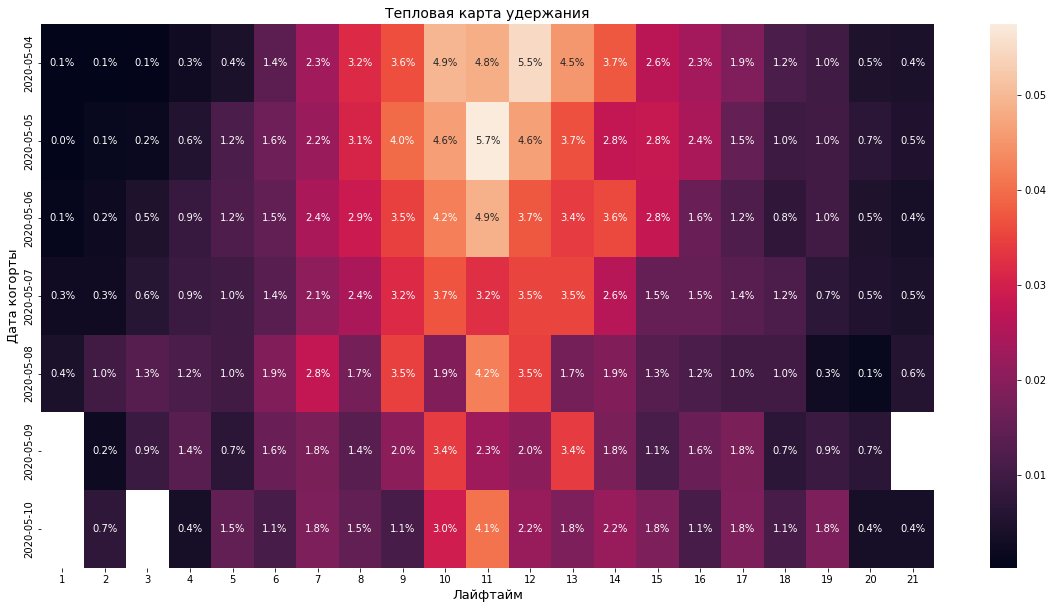

In [51]:
retention_group = data_game_actions.query('event == "finished_stage_1"').pivot_table(
    index=["cohort_date"], columns="lifetime", values="user_id", aggfunc="nunique"
)

retention_group = retention_group.merge(
    cohort_info.iloc[:, 1:].drop_duplicates(), on="cohort_date"
).set_index("cohort_date")
retention_group = retention_group.div(retention_group["cohort_size"], axis=0)
plt.figure(figsize=(20, 10))
sns.heatmap(retention_group.loc[:, 1:21], annot=True, fmt=".1%")
plt.title("Тепловая карта удержания", fontsize=14)
plt.xlabel("Лайфтайм", fontsize=13)
plt.ylabel("Дата когорты", fontsize=13)
plt.show()

#### Вывод  
Существующую сиситему монетизации приложения можно считать относительно успешной, т.к. каждый из активных пользователей хотя бы 1 раз в день просматривает рекламное сообщение. В стоимостном выражении сумма потраченная на рекламную кампанию, меньше суммы заработанной на рекламных показах в игре на 1353 единицы. Рентабельность действующей системы монетизации 17,8%.

Однако заметны проблемы с постройками типа 'assembly_shop', причины которых необходимо проанализировать глубже. Это негативно сказывается и на монетизации, т.к. выпадает одно из рекламных действий, так и возможно на удовлетворенности игрой (слабое удержание).  

Наибольшее число завершений первого уровня приходится на 7-15 лайфтайм по каждой из когорт. Вероятность того, что пользователь продолжит играть после 21 лайфтайма весьма мала.

Далее рассмотрим варианты повышения эффективности монетизации за счет увеличение числа показов рекламных сообщений.

### Разработка новых схем монетизации

Дополнительные показы рекламы можно осуществлять:  
- после завершения уровня. На имеющихся данных это принесло бы 5817 показов (+ 4,5%) или 407 дополнительных единиц. 
- повторный заход в игру, в последующие дни после первого посещения (1 раз в день). На имеющихся данных это принесло бы 81625 показов (+64%). Дополнительные поступления составили бы 5713 единиц.  

При действующей системе монетизации игрок видел рекламное сообщение в среднем 9,4 раза за игру, при дополнительных показах при ежедневном входе этот показатель увеличился бы до 15,4 раз за игру.  

Второй вариант численно предпочтительнее, но необходимо провести тесты для определения лояльности игроков к таким действиям.

In [52]:
print(profiles.agg({"number_event": "sum", "user_id": "nunique"}).round(3))
print(profiles["returns"].sum())

number_event    127956
user_id          13576
dtype: int64
81625


<b> Вывод </b>  

По условию задачи реклама пока не показывается совсем, формулировка "Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки." Поэтому предположить вывод, что пользователей отпугнула реклама было бы некорректно. Пользователи перестают заходить в приложение по каким-то другим причинам. 

Чтобы оценить много это или мало, что 40% пользователей захотело закончить первый уровень тоже недостаточно информации. Необходимы данные о типичных показателях мобильных игр в целом, по жанру и по тематике игры, а также плановый показатель маркетинга.  
    
Мы смогли "оцифровать" предполагаемую модель монетизации и предложили как увеличить сумму рекламных выплат. Снизить этот показатель при текущем варианте возможным не представляется, т.к. окупаемость на очень высоком уровне - 18%.


## Анализ стоимости рекламы

- стоимость рекламных расходов на 1 пользователя по каналам за весь период наблюдения
- стоимость рекламных расходов на 1 пользователя по каналам и по дням

In [53]:
# добавим к DF данные о канале привлечения пользователя и группируем по этому каналу
data_game_actions = data_game_actions.merge(data_user_source, on="user_id")

In [54]:
group_ad_source = (
    data_game_actions.groupby(["source"])
    .agg({"user_id": "nunique"})
    .rename(columns={"user_id": "users"})
)
group_ad_source = group_ad_source.merge(
    data_ad_costs.groupby("source").agg({"cost": "sum"}), on="source"
)
group_ad_source["per_user"] = group_ad_source["cost"] / group_ad_source["users"]

In [55]:
group_ad_source

,users,cost,per_user
source,,,
facebook_ads,2726,2140.904643,0.785365
instagram_new_adverts,3347,2161.441691,0.645785
yandex_direct,4817,2233.111449,0.463590
youtube_channel_reklama,2686,1068.119204,0.397662


Самая высокая стоимость привлечения в игру одного человека у канала "facebook_ads" - 0,78 единиц, самая низкая у "youtube_channel_reklama" - 0,40 единиц. Однако наибольшее число привлеченных пользователей у "yandex_direct" - 4817 человек. Канал "instagram_new_adverts" демонстрирует "средние" значения по всем показателям.

Далее проанализируем эффективность рекламных затрат по когортам. Для этого в DF с рекламными затратами добавим еще один столбец дата рекламы + 1 день,чтобы провести соответствие между двумя группами данных.

In [56]:
data_ad_costs["cohort_date"] = data_ad_costs["day"] + timedelta(days=1)
data_ad_costs.head()

,source,day,cost,cohort_date
0,facebook_ads,2020-05-03,935.882786,2020-05-04
1,facebook_ads,2020-05-04,548.354480,2020-05-05
2,facebook_ads,2020-05-05,260.185754,2020-05-06
3,facebook_ads,2020-05-06,177.982200,2020-05-07
4,facebook_ads,2020-05-07,111.766796,2020-05-08


In [57]:
group_ad_cohort = data_game_actions.groupby(["source", "cohort_date"]).agg(
    {"user_id": "nunique"}
)
group_ad_cohort = group_ad_cohort.merge(
    data_ad_costs[["cohort_date", "source", "cost"]], on=["cohort_date", "source"]
).rename(columns={"cost": "ad_cost"})

group_building_cohort = (
    data_game_actions.query('event == "building"')
    .groupby(["cohort_date", "source"])
    .agg({"event": "count"})
    .rename(columns={"event": "ad_income"})
)

group_ad_cohort = group_ad_cohort.merge(
    group_building_cohort, on=["cohort_date", "source"]
)
group_ad_cohort["ad_income"] = group_ad_cohort["ad_income"] * 0.07
group_ad_cohort["ad_profit"] = group_ad_cohort["ad_income"] - group_ad_cohort["ad_cost"]

group_ad_cohort["costs_per_user"] = (
    group_ad_cohort["ad_cost"] / group_ad_cohort["user_id"]
)
group_ad_cohort["incomes_per_user"] = (
    group_ad_cohort["ad_income"] / group_ad_cohort["user_id"]
)
group_ad_cohort.head()

,cohort_date,source,user_id,ad_cost,ad_income,ad_profit,costs_per_user,incomes_per_user
0,2020-05-04,facebook_ads,1184,935.882786,874.58,-61.302786,0.790442,0.738666
1,2020-05-05,facebook_ads,694,548.354480,482.65,-65.704480,0.790136,0.695461
2,2020-05-06,facebook_ads,345,260.185754,216.09,-44.095754,0.754162,0.626348
3,2020-05-07,facebook_ads,224,177.982200,125.23,-52.752200,0.794563,0.559063
4,2020-05-08,facebook_ads,139,111.766796,66.43,-45.336796,0.804078,0.477914


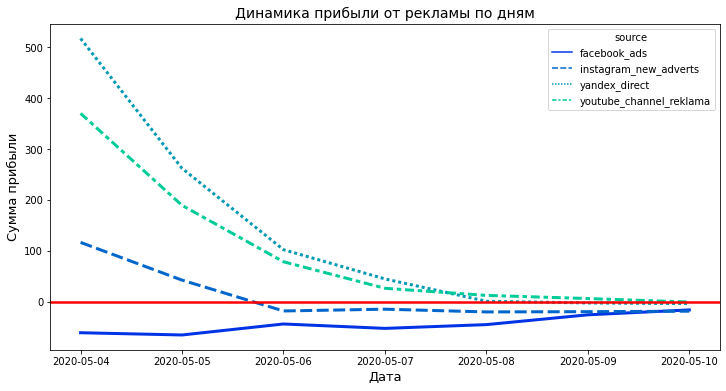

In [58]:
# построим график динамики дохода от рекламных показов в разрезе канала привлечения пользователей
plt.figure(figsize=(12, 6))
lchart = sns.lineplot(
    data=group_ad_cohort.pivot_table(
        index="cohort_date",
        columns="source",
        values="ad_profit",
        aggfunc="min",
    ),
    linewidth=3,
    palette=("winter"),
    linestyle="-.",
)
plt.axhline(y=0, color="red", linewidth=2.5)
plt.xlabel("Дата", fontsize=13)
plt.ylabel("Сумма прибыли", fontsize=13)
plt.title("Динамика прибыли от рекламы по дням", fontsize=14)
plt.show()

На графике хорошо заметно, что привлечение пользователей через канал 'facebook_ads' для всех когорт было убыточно. Каналы 'instagram_new_adverts' и 'yandex_direct' до когорты третьего и пятого дня показывали положительную доходность, хоть и со снижением по сравнению с когортой первого дня, однако в последствии также ушли ниже точки безубыточности. Реклама канала 'youtube_channel_reklama' показала наилучший результат - прибыльность выше точки безубыточности у всех когорт.  
В целом за период наблюдения получена положительная окупаемость рекламы (1353 единицы дохода), однако динамика от первого к последнему дню по когортам отрицательная.  
Далее на графиках рассмотрим динамику затрат на 1 пользователя и полученный от 1 рекламный доход.

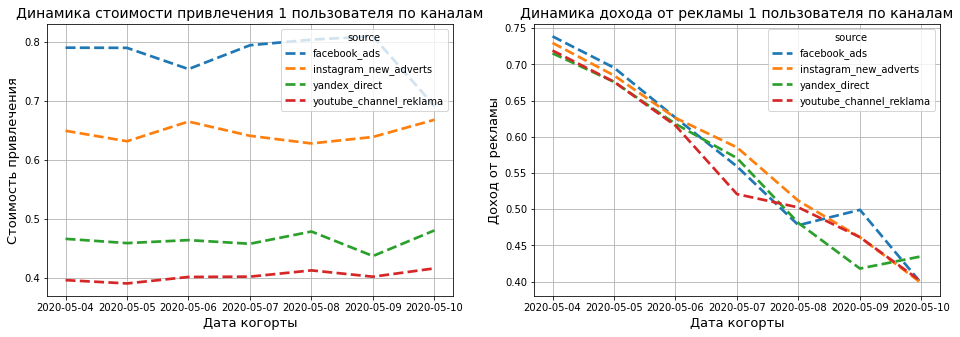

In [59]:
plt.figure(figsize=(16, 5))

ax1 = plt.subplot(1, 2, 1)

group_ad_cohort.pivot_table(
    index="cohort_date", columns="source", values="costs_per_user", aggfunc="min"
).plot(grid=True, linestyle="--", linewidth=2.7, ax=ax1)

plt.ylabel("Стоимость привлечения", fontsize=13)
plt.xlabel("Дата когорты", fontsize=13)
plt.title("Динамика стоимости привлечения 1 пользователя по каналам", fontsize=14)

ax2 = plt.subplot(1, 2, 2, sharex=ax1)

group_ad_cohort.pivot_table(
    index="cohort_date", columns="source", values="incomes_per_user", aggfunc="min"
).plot(grid=True, linestyle="--", linewidth=2.7, ax=ax2)

plt.ylabel("Доход от рекламы", fontsize=13)
plt.xlabel("Дата когорты", fontsize=13)
plt.title("Динамика дохода от рекламы 1 пользователя по каналам", fontsize=14)

plt.show()

#### Вывод  
Каналы "facebook_ads" и "instagram_new_adverts" характеризуются более высокой стоимостью привлечения 1 пользователя и большей изменчивостью значения этого показателя в течение рекламной кампании.  
Каналы "youtube_channel_reklama" и  "yandex_direct" напротив менее дорогие и стоимость привлечения изменяется слабо.  
Однако доход от рекламы 1 игрока (связанный с количеством построенных ими объектами) отличается практически в два раза по сравнению с когортой первого и последнего дня. Очевидно рекламамная кампания не может признаться успешной.

## Работа со статистическими гипотезами  
### Вариант 1
Определим зависимость количества времени нахождения пользователя в игре от способа завершения уровня
- нулевая гипотеза H0:  
    среднее время, необходимое для завершения уровня *победой* над другим игроком **равно** среднему времени, необходимому для завершения *реализацией проекта* 
- альтернативная гипотеза H1:  
    среднее время, необходимое для завершения уровня *победой* над другим игроком **не равно** среднему времени, необходимому завершения *реализацией проекта*   

In [60]:
time_finishers_builder = data_game_actions[
    (data_game_actions["user_id"].isin(finishers_builder))
    & (data_game_actions["event"] == "finished_stage_1")
]["lifetime"]
time_finishers_builder.head()

19     11
98     14
112    15
150    11
221    11
Name: lifetime, dtype: int64

In [61]:
time_finishers_warrior = data_game_actions[
    (data_game_actions["user_id"].isin(finishers_warrior))
    & (data_game_actions["event"] == "finished_stage_1")
]["lifetime"]
time_finishers_warrior.head()

32     12
49      7
73     12
134     8
172     7
Name: lifetime, dtype: int64

Перед проверкой гипотез проверим распределение и дисперсии выборок:

In [62]:
var_builder = np.var(time_finishers_builder, ddof=1)
var_warrior = np.var(time_finishers_warrior, ddof=1)

In [63]:
print(
    f"Дисперсии выборок: \n окончание первого уровня постройкой {var_builder} \n окончание первого уровня победой {var_warrior}"
)

Дисперсии выборок: 
 окончание первого уровня постройкой 12.408867586757813 
 окончание первого уровня победой 16.849998558288398


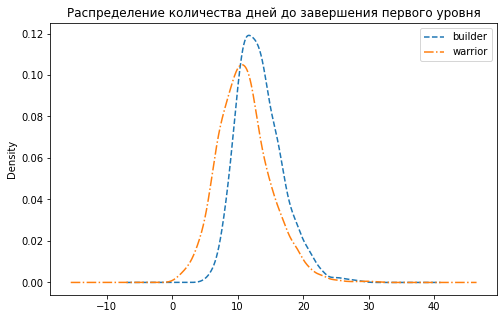

In [64]:
plt.figure(figsize=(8, 5))
time_finishers_builder.plot.density(style="--", label="builder").legend()
time_finishers_warrior.plot.density(style="-.", label="warrior").legend()
plt.title("Распределение количества дней до завершения первого уровня")
plt.show()

Дисперсии выборок не равны, их распределения близки к нормальным

In [65]:
alpha = 0.05

results = st.ttest_ind(time_finishers_builder, time_finishers_warrior, equal_var=False)
print("p-значение: ", results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  6.5704667556436364e-105
Отвергаем нулевую гипотезу


Согласно полученному значению p-value (6.5704667556436364e-105) можно отвергнуть нулевую гипотезу.  

Значение p-value значительно ниже критического уровня статистической значимости (установлено для проверки этой гипотезы на уровне 0,05).  

Таким образом альтернативная не отвергается - *среднее время, необходимое для завершения первого уровня победой над другим игроком **не равно** среднему времени, необходимому завершения реализацией проекта*

### Вариант 2
Зависимость количества "рекламных" действий пользователя в игре от способа завершения уровня
- нулевая гипотеза H0:  
    среднее количество "рекламных" действий пользователя при схеме игры *победа над врагом* **равно** среднему количеству действий действий пользователя при схеме игры *реализация проекта*.
- альтернативная гипотеза H1:  
   среднее количество "рекламных" действий пользователя при схеме игры *победа над врагом* **не равно** среднему количеству действий действий пользователя при схеме игры *реализация проекта*.   

In [66]:
event_finishers_builder = (
    data_game_actions[
        (data_game_actions["user_id"].isin(finishers_builder))
        & (data_game_actions["event"] == "building")
    ]
    .groupby("user_id")
    .agg({"event": "count"})["event"]
)

event_finishers_builder.head()

user_id
006380d6-67a6-45de-ab1e-6eb54ad8dbe8    11
00be7371-fa79-4fbd-b8e7-8ba32e3f8f82    12
00c2b9f2-2615-439c-aed0-6974e4c6c1c1    11
00de2809-403e-4476-a2f7-ca1b11700190    13
00e83261-5fd4-4939-9616-802b5a0202c6    13
Name: event, dtype: int64

In [67]:
event_finishers_warrior = (
    data_game_actions[
        (data_game_actions["user_id"].isin(finishers_warrior))
        & (data_game_actions["event"] != "finished_stage_1")
    ]
    .groupby("user_id")
    .agg({"event": "count"})["event"]
)

event_finishers_warrior.head()

user_id
001d39dc-366c-4021-9604-6a3b9ff01e25     8
003ee7e8-6356-4286-a715-62f22a18d2a1     8
004074f8-251a-4776-922c-8348dca1a2f6    12
00464e5e-28ed-4be6-bf44-517ef7b3937b     8
0056c007-c082-43cc-bdef-afc49bca4cb9     3
Name: event, dtype: int64

Также перед проверкой и этих гипотез проверим распределение и дисперсии выборок:

In [68]:
var_builder_e = np.var(event_finishers_builder, ddof=1)
var_warrior_e = np.var(event_finishers_warrior, ddof=1)

In [69]:
print(
    f"Дисперсии выборок: \n окончание первого уровня постройкой {var_builder_e} \n окончание первого уровня победой {var_warrior_e}"
)

Дисперсии выборок: 
 окончание первого уровня постройкой 4.676502331836245 
 окончание первого уровня победой 9.360717395692165


In [70]:
# plt.figure(figsize=(8,5))
# user_score_xone.plot.density(style='--', label='XOne')
# user_score_pc.plot.density(style='-.', label='PC')
# plt.legend()
# plt.show()

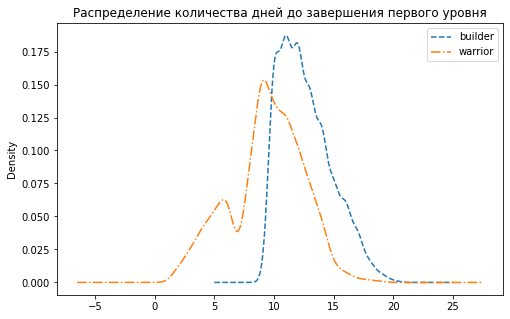

In [71]:
plt.figure(figsize=(8, 5))
event_finishers_builder.plot.density(style="--", label="builder").legend()
event_finishers_warrior.plot.density(style="-.", label="warrior").legend()
plt.title("Распределение количества дней до завершения первого уровня")
plt.show()

Дисперсии выборок не равны, их распределения близки к нормальным, однако у значений выборки победа заметны два пика.

In [72]:
alpha = 0.05

results = st.ttest_ind(
    event_finishers_builder, event_finishers_warrior, equal_var=False
)
print("p-значение: ", results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.0
Отвергаем нулевую гипотезу


Согласно полученному значению p-value (0.0) можно отвергнуть нулевую гипотезу.  

Значение p-value значительно ниже критического уровеня статистической значимости (установлено для проверки этой гипотезы на уровне 0,05).  

Таким образом альтернативная не отвергается - *среднее количество "рекламных" действий пользователя при схеме игры победа над врагом **не равно** среднему количеству действий действий пользователя при схеме игры реализация проекта.*

## Вывод по проекту
- текстовые выводы
- подготовка презентации
- подготовка дашбордов

По результатам произведенного исследования можно сделать следующие выводы:  

**По количеству пользователей**:  
- за период наблюдения 2020-06-05 - 2020-05-04 (31 день) в игре зарегистрировалось 13576 пользователя  
- из них завершило первый уровень игры 5817 игроков (42.8% от всего числа игроков)  
- 1866 человек завершило уровень постройкой  и 3951 человек победой над другим игроком (32% и 68% соответственно от завершивших первый уровень).


**По количеству действий, совершенных пользователями**:  
- среднее число действий игроков закончивших первый уровень в зависимости от когорты составляет от 11,3 до 7,9.
- у незакончивших этот показатель составляет от 9,8 до 5,1.

**По средней продолжительности игры в днях**:
- у закончивших победой продолжительность составляет 10,5 дней при 9,4 совершенных действиях
- у закончивших постройкой продолжительность составляет 12,9 дней при 13,6 совершенных действиях
- у незакончивших уровень продолжительность составляет 9,7 дней при 8,7 совершенных действиях.

**По источнику привлечения пользователей**
- наибольшее число пользователей пришло с рекламного канала yandex (35.5%), 
- на втором месте instagram (24.7%), 
- каналы facebook и youtube делят третье место (20.1% и 19.8% соответственно).

**По стоимости привлечения пользователей:**
- каналы "facebook_ads" и "instagram_new_adverts" характеризуются более высокой стоимостью привлечения 1 пользователя и большей изменчивостью значения этого показателя в течение рекламной кампании.
- каналы "youtube_channel_reklama" и "yandex_direct" напротив менее дорогие и стоимость привлечения изменяется слабо.  

**По полученому доходу от рекламы:**
- привлечение пользователей через канал 'facebook_ads' для всех когорт было убыточно. 
- каналы 'instagram_new_adverts' и 'yandex_direct' до когорты третьего и пятого дня показывали положительную доходность, хоть и со снижением по сравнению с когортой первого дня, однако в последствии также ушли ниже точки безубыточности. 
- реклама канала 'youtube_channel_reklama' показала наилучший результат - прибыльность выше точки безубыточности у всех когорт.

В ходе анализа были проверены **две статистические гипотезы** :
1. о равенстве / неравенстве времени, необходимое для завершения уровня победой над другим игроком и необходимому для завершения реализацией проекта
2. о равенстве / неравенстве количество "рекламных" действий пользователя при схеме игры победа над врагом и при схеме игры реализация проекта.  

В обеих гипотезах не были отвергнуты альтернативные гипотезы (о неравенстве показателей).  
Количество построек и, как следствие, просмотров рекламных сообщений, пользователями выбравшими стратегию проекта больше, нежели у выбравших стратегию победы. Таким образом, для поддержания более "длинного" варианта прохождения игры необходимо предложить игрокам "плюшки". Введение условных "штрафов" за "короткий" путь может негативно отразится на лояльности к игре. 

Проведен анализ существующей **схемы монетизации проекта**:  
Существующую сиситему монетизации приложения можно считать относительно успешной, т.к. каждый из активных пользователей хотя бы 1 раз в день просматривает рекламное сообщение. В стоимостном выражении сумма потраченная на рекламную кампанию, меньше суммы заработанной на рекламных показах в игре на 1353 единицы. Рентабельность действующей системы монетизации 17,8%. Невысокая окупаемость не позволяет разрабатывать схемы со снижением количества рекламных показов, во избежании получения убытка.

В качестве вариантов дополнительных показов рекламы можно считать:
- показа рекламы после завершения уровня не в зависимости от способа его завершения. На имеющихся данных это принесло бы 5817 показов (+ 4,5%) или 407 дополнительных единиц. 
- при повторном заходе в игру, в последующие дни после первого посещения (1 раз в день). На имеющихся данных это принесло бы 81625 показов (+64%). Дополнительные поступления составили бы 5713 единиц.  
При действующей системе монетизации игрок видел рекламное сообщение в среднем 9,4 раза за игру, при дополнительных показах при ежедневном входе этот показатель увеличился бы до 15,4 раз за игру на первом уровне.

Команде разработки необходимо передать обнаруженые проблемы с постройками типа 'assembly_shop', причины которых необходимо проанализировать глубже. Это негативно сказывается и на монетизации, т.к. выпадает одно из рекламных действий, так и возможно на удовлетворенности игрой (слабое удержание).